In [1]:
cd /home/mars/src_aiai

/home/mars/src_aiai


In [2]:
import pickle
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from src.visualisation import compare, print_statistics, plot_statistics
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

In [5]:
data = "COCO"
ISNR = 30

In [6]:
metrics = [
    ("PSNR", peak_signal_noise_ratio),
    ("SSIM", structural_similarity),
    ("MSE", mean_squared_error)
]

In [7]:
results = [
#     ("Pseudo-inverse", "PseudoInverse", ""),
#     ("Primal-Dual", "PD", ""), 
#     ("Unet known", "UNet_var", "_known"),
#     ("Unet transfer known", "UNet_var", "_transfer_known"),
#     ("Unet generelaized", "UNet_var", "_generalized"),    
#     ("Unet transfer generalized", "UNet_var", "_transfer_generalized"),
#     ("GUnet known", "GUNet_var", "_known"),
    
    ("Unet known", "UNet_var", "_known_new2"),
    ("Unet general", "UNet_var", "_general_new2"),    
    ("Unet general known", "UNet_var", "_general_known_new2"),
    ("Unet specific known", "UNet_var", "_specific_known_new2"),
    ("Unet specific", "UNet_var", "_specific_new2"),
    
    
#     ("GUnet known", "GUNet_var", "_generalized_test_some_subs"),
#     ("GUnet known", "GUNet_var", "_generalized_test_smart_sel"),
#     ("GUnet known", "GUNet_var", "_generalized_test_smart_sel_short"),
    
#     ("GUnet transfer known", "GUNet_var", "_transfer_known"),
#     ("GUnet gen_weight", "GUNet_var", "_generalized_weighted"),
#     ("GUnet gen_weight", "GUNet_var", "_generalized_weighted_exclusion"),
#     ("GUnet gen_weight", "GUNet_var", "_generalized_weighted_exclusion_big"),
#     ("GUnet generalized", "GUNet_var", "_generalized"),
#     ("GUnet transfer generalized", "GUNet_var", "_transfer_generalized"),
    
#     ("GUnet transfer generalized", "GUNet_var", "_transfer_generalized_short"),
    
#     ("GUnet", "GUNet_var", "_known_adadelta"),
#     ("GUnet", "GUNet_var", "_generalized_adadelta"),
#     ("GUnet", "GUNet_var", "_transfer_generalized_adadelta"),
#     ("GUnet", "GUNet_var", "_transfer_known_adadelta"),
#     ("GUnet", "GUNet_var", "_20x5"),
    
    

]

In [8]:
data = "TNG"

In [9]:

def print_statistics(statistics, results, metrics, latex=False):
    if latex:
        separator = " & "
        lines = ""
    else:
        separator = "|"
        lines = "|"
    

    print( f"{'Name':75}", end=separator)
    for metric, f in metrics:
        print(f"{metric:20}", end=separator)
    if latex:
        print("\\\\", end="")
    print()
    for name, set, _ in (results):
        if name in statistics.Method.values:
            print(f"{name+'_'+set:75}", end=separator)
            for metric, f in metrics:
                if latex:
                    print(f"$ {np.nanmean(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):8.3f} \pm {np.std(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):7.3f} $", end=separator)
                else:
                    print(f"{np.nanmedian(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):8.3f} \pm {np.std(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):7.3f}", end=separator)
                
                # median = np.median(statistics[metric][(statistics.Method == name) * (statistics.Set == set)])
                # smad = 1.4826* np.median(np.abs(statistics[metric][(statistics.Method == name) * (statistics.Set == set)] - median))
                # print(f"{median:8.3f} \pm {smad:7.3f}|", end="")
            if latex:
                print("\\\\", end="")
            print()

In [45]:
def plot_statistics(statistics, metrics, ylims=[[0,40], [0,1], [0, 0.04]], split=True, order=None, save_base="./plots/violinplot", title="", rot=90):
    #TODO add some better ytick labels, currently to many/much precision
    
    for idx, (metric, _) in enumerate(metrics):
        plt.figure(figsize=(9,6))
        sns.set_style('whitegrid')
        sns.violinplot(data=statistics, x='name', y=metric, split=split, hue='Set', palette="Set3", bw=.2, cut=1, linewidth=1, inner='quart', orientation='v', order=order)
        # sns.violinplot(data=statistics, x='Method', y=metric, split=False, hue='Set', palette="Set3", bw=.2, cut=1, linewidth=1, inner='quart', orientation='v')
        if metric == "PSNR":
            metric += " (dB)"
        plt.ylabel(metric, fontsize='x-large')
        plt.xlabel("")
        plt.title(title, fontsize='x-large')
        plt.tick_params(labelsize='large', rotation=rot)
        # ax[idx].xaxis.label.set_size('x-large')
        sns.despine(left=False, bottom=False)
        plt.legend(loc="lower right", fontsize='large')
        plt.axis(ymin = ylims[idx][0], ymax=ylims[idx][1])
        plt.tight_layout()
        plt.savefig(save_base + f"_{idx+1}.pdf", transparent=True)
        plt.show()
    

In [11]:
def compare_multiple(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", cbar_anchor=(1.2, 0), rot=0, vmin=None, vmax=None, ylabel=""):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)
    
    images = [np.rot90(i, rot) for i in images]
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
        figsize=(ncols*6, nrows*6 +1), squeeze=False)

    a = ax[0,0].imshow(images[0])    
    ax[0,0].set_title(titles[0])
    ax[0,0].set_ylabel(ylabel)
    if vmin is None:
        vmin, vmax = a.get_clim()
    for i in range(0, nrows):
        for j in range(ncols):
            if i +j*nrows >= len(images):
                break
            if same_scale:
                im = ax[i,j].imshow(images[j + i*ncols], 
                    vmin=vmin, vmax=vmax, cmap=cmap)
            else:
                im = ax[i,j].imshow(images[j + i*ncols], cmap=cmap)
            if j % ncols != 0:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] + f"\n(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                else:
                    ax[i,j].set_title(f"(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                    
            else:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] +"\n")
                else:
                    ax[i,j].set_title(titles[j + i*ncols])
                    
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    if colorbar:
#         plt.colorbar(im, ax=ax, anchor=cbar_anchor, shrink=.8)
        plt.colorbar(im, ax=ax,anchor=cbar_anchor, fraction=0.046, pad=0.04, shrink=.87)
    plt.subplots_adjust(wspace=.01)

# TNG

In [12]:
operator = "NUFFT_Random_var"
network = "GUNet"
# train_predict = np.load(f"data/processed/TNG/{operator}/train_predict_{network}_{ISNR}dB" + "_generalized" + ".npy")


In [41]:
tng_results = [
#     ("Pseudo-inverse", "PseudoInverse", ""),
#     ("Primal-Dual", "PD", ""), 
#     ("Unet known", "UNet_var", "_known"),
#     ("Unet general", "UNet_var", "_general"),    
#     ("Unet general2known", "UNet_var", "_general_known"),
#     ("Unet specific2known", "UNet_var", "_specific_known"),

    ("True\ncoverage\n", "UNet_var", "_known_new2"),
    ("Single\ncoverage\n", "UNet_var", "_specific_new2"),
    ("Single\ncoverage\nTransfer", "UNet_var", "_specific_known_new2"),
    ("Distribution\nof coverages\n", "UNet_var", "_general_new2"),    
    ("Distribution\nof coverages\nTransfer", "UNet_var", "_general_known_new2"),
    #     ("GUnet known", "GUNet_var", "_known"),
#     ("GUnet general", "GUNet_var", "_general"),
#     ("GUnet specific2known", "GUNet_var", "_specific_known"),
#     ("GUnet general2known", "GUNet_var", "_general_known"),

#     ("GUnet known weighted", "GUNet_var", "_known_weighted"),
#     ("GUnet general weighted", "GUNet_var", "_general_weighted"),
#     ("GUnet specific2known weighted", "GUNet_var", "_specific_known_weighted"),
#     ("GUnet general2known weighted", "GUNet_var", "_general_known_weighted"),
]

for operator in ["NUFFT_Random_var"]:
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "Method", "set"])

    for name, network, post in tng_results:
        try:
            df = pd.read_csv(f"./results/TNG/{operator}/statistics_{network}_{ISNR}dB{post}.csv")            
            df["name"] = name
            sel = abs(df["SSIM"] - np.median(df["SSIM"]))/np.median(df["SSIM"]) > 0.10 
            df = df[~sel]
            if statistics.empty:
                statistics = df
            else:
                statistics = statistics.append(df, ignore_index=False)
            print("loaded", network, post)
        except:
            pass
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True)

loaded UNet_var _known_new2
loaded UNet_var _specific_new2
loaded UNet_var _specific_known_new2
loaded UNet_var _general_new2
loaded UNet_var _general_known_new2


In [42]:
print_statistics(statistics, [(f"{j} NUFFT_Random_var {k[1:]}", "train", k) for i,j,k in tng_results], metrics)

Name                                                                       |PSNR                |SSIM                |MSE                 |
UNet_var NUFFT_Random_var known_new2_train                                 |  42.332 \pm   1.958|   0.987 \pm   0.007|   0.000 \pm   0.000|
UNet_var NUFFT_Random_var specific_new2_train                              |  27.022 \pm   3.148|   0.877 \pm   0.029|   0.002 \pm   0.002|
UNet_var NUFFT_Random_var specific_known_new2_train                        |  36.630 \pm   3.155|   0.974 \pm   0.015|   0.000 \pm   0.008|
UNet_var NUFFT_Random_var general_new2_train                               |  31.776 \pm   2.871|   0.948 \pm   0.023|   0.001 \pm   0.001|
UNet_var NUFFT_Random_var general_known_new2_train                         |  34.456 \pm   2.792|   0.962 \pm   0.021|   0.000 \pm   0.000|


In [43]:
print_statistics(statistics, [(f"{j} NUFFT_Random_var {k[1:]}", "test", k) for i,j,k in tng_results], metrics)

Name                                                                       |PSNR                |SSIM                |MSE                 |
UNet_var NUFFT_Random_var known_new2_test                                  |  37.983 \pm   2.994|   0.978 \pm   0.013|   0.000 \pm   0.000|
UNet_var NUFFT_Random_var specific_new2_test                               |  27.449 \pm   3.087|   0.877 \pm   0.029|   0.002 \pm   0.002|
UNet_var NUFFT_Random_var specific_known_new2_test                         |  35.889 \pm   2.932|   0.971 \pm   0.015|   0.000 \pm   0.000|
UNet_var NUFFT_Random_var general_new2_test                                |  31.887 \pm   2.884|   0.948 \pm   0.023|   0.001 \pm   0.001|
UNet_var NUFFT_Random_var general_known_new2_test                          |  34.185 \pm   2.748|   0.961 \pm   0.020|   0.000 \pm   0.000|


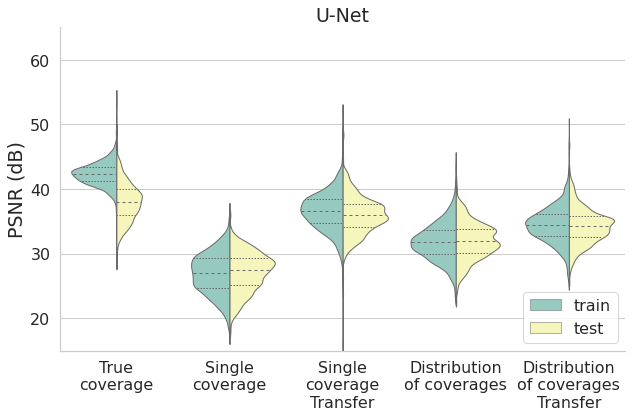

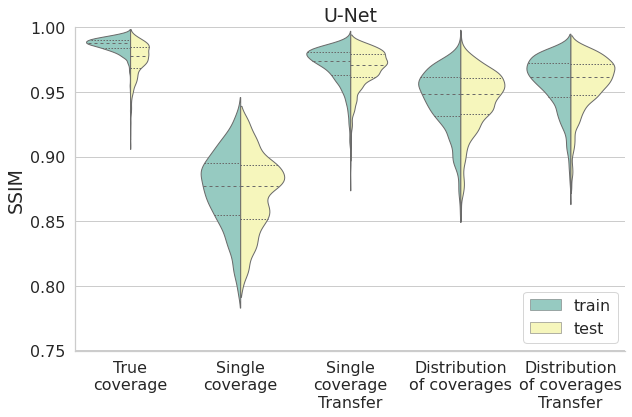

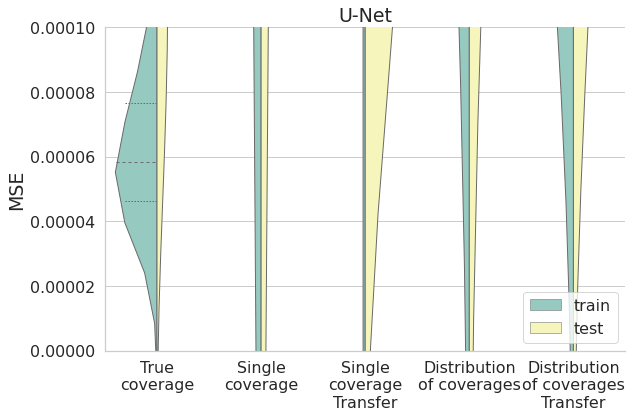

In [48]:
sns.set_context("notebook", font_scale=1.1)
# sns.set_context("notebook", font_scale=1.3)
# sns.set_context("paper", font_scale=1.3)


plot_statistics(statistics, metrics, ylims=[[15,65], [0.75,1], [0, 0.0001]], save_base="./plots_ri/TNG_violin_UNet_", title="U-Net", rot=0) #, order=["PseudoInverse", "PD", "UNet", "GUnet"])

In [62]:
tng_results = [
    ("Dirty image", "PseudoInverse", ""),
    ("True coverage", "UNet_var", "_known_new2"),
    ("Single coverage", "UNet_var", "_specific_new2"),
    ("Single coverage transfer", "UNet_var", "_specific_known_new2"),
    ("Distribution of coverages", "UNet_var", "_general_new2"),    
    ("Distribution of coverages transfer", "UNet_var", "_general_known_new2"),
]

data = "TNG"
operator = "NUFFT_Random_var"

true = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")
sel = [2, 6, 8, 11, 21]
res = [[true[i] for i  in sel]]
titles = ["Reference"]

for name, network, post in tng_results:
    try:
#         print(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res.append([ims[i] for i in sel])
        titles.append(name)
    except:
        pass

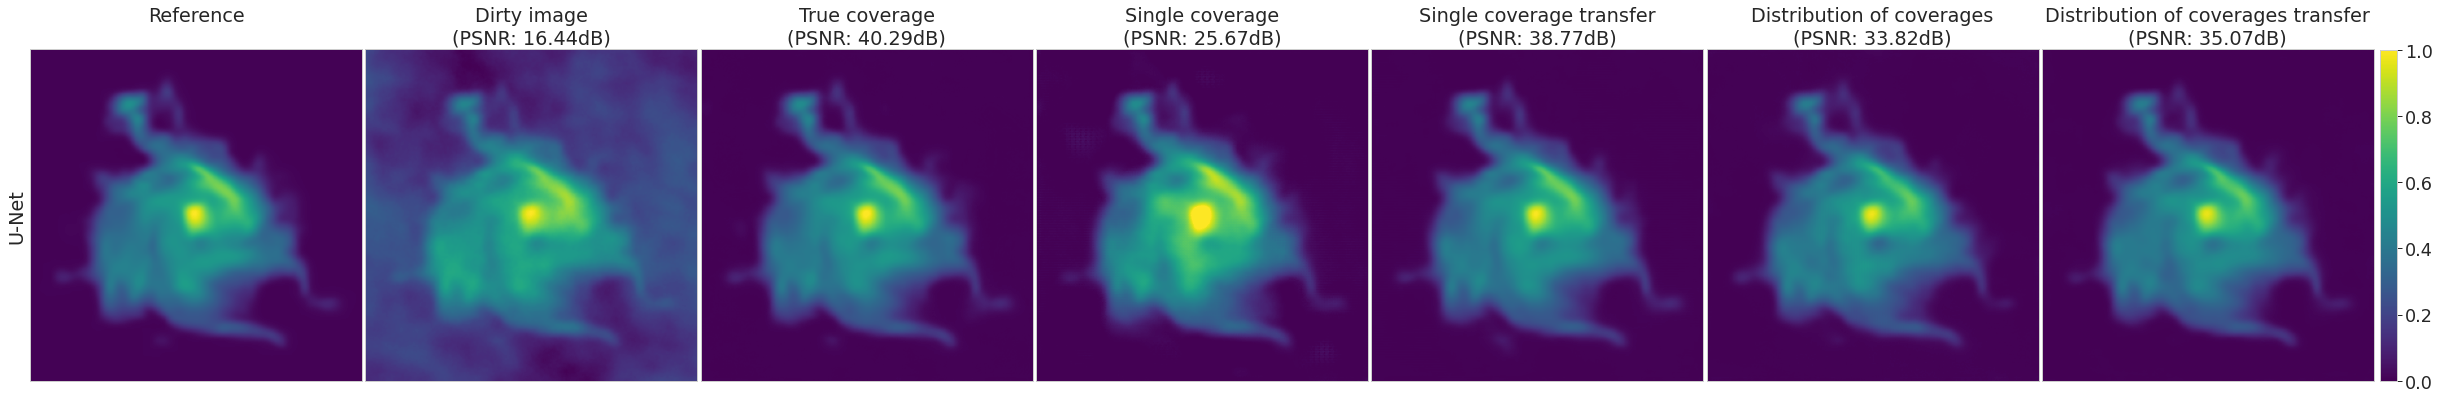

In [63]:
# for poster: 
# sns.set_context('paper', font_scale=1.8)
sns.set_context('paper', font_scale=2.0)

compare_multiple(np.array(res)[:,0], titles=titles, rot=2, nrows=1, ncols=4, colorbar=True, cbar_anchor=(1.25,.5), same_scale=True, vmin=0, vmax=1, cmap="viridis", ylabel="U-Net")
plt.savefig("./plots_ri/examples_TNG_UNet_0_poster.pdf")

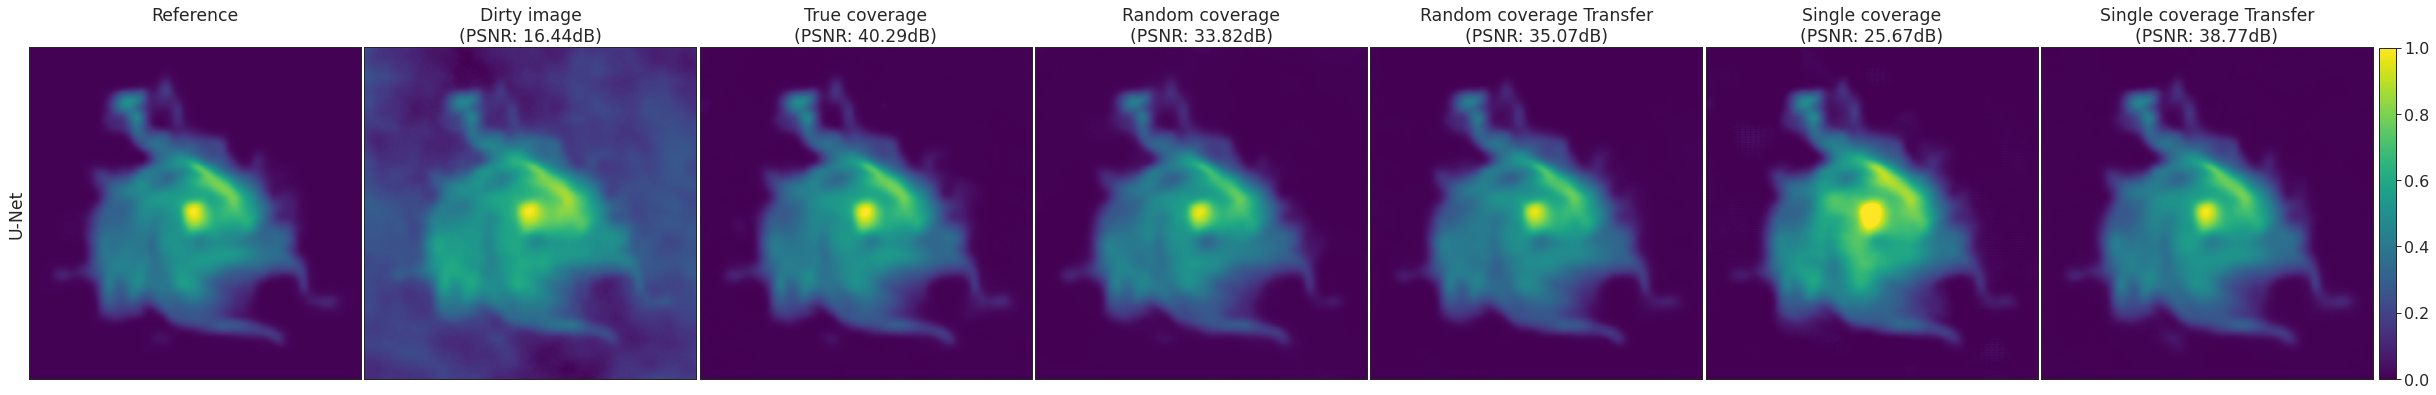

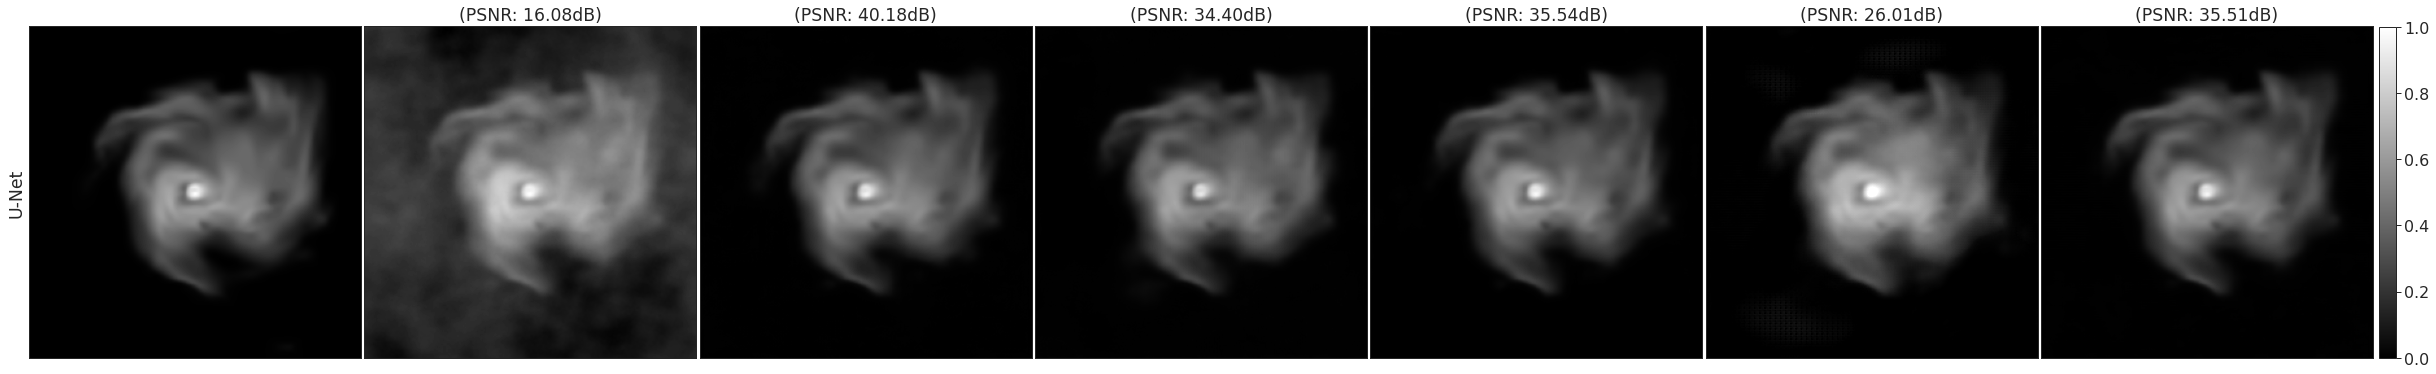

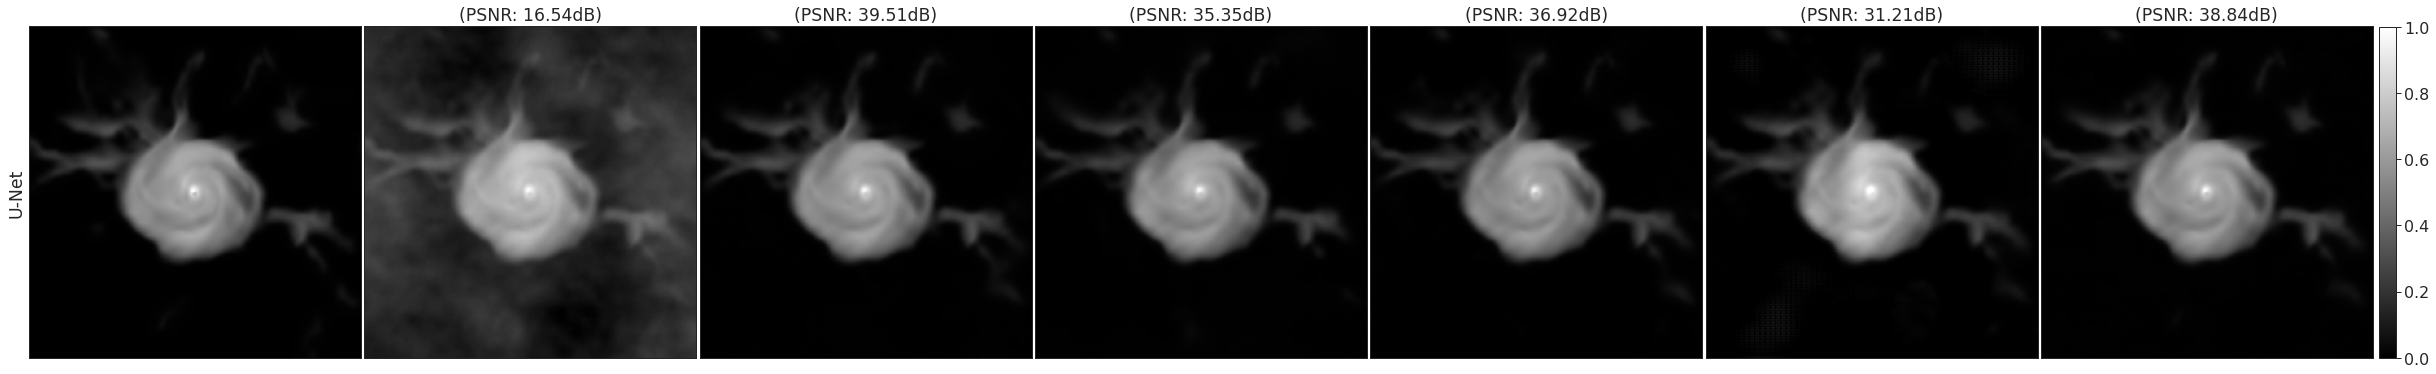

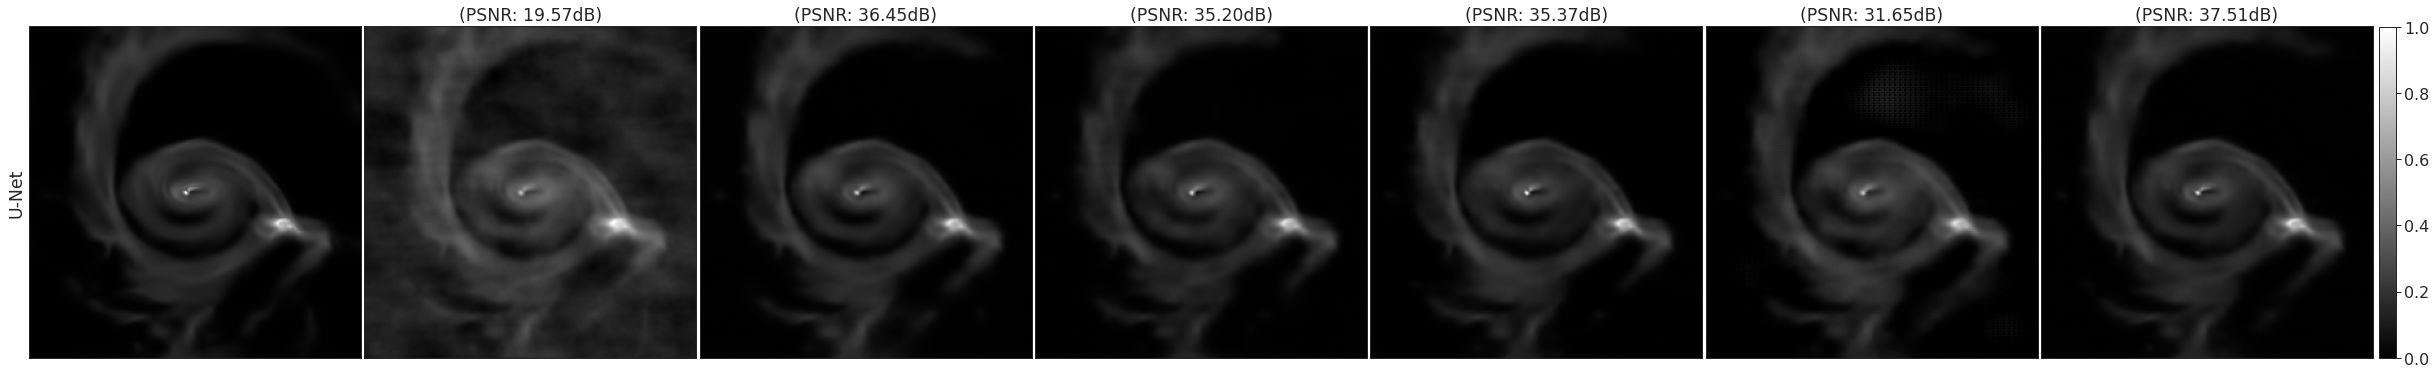

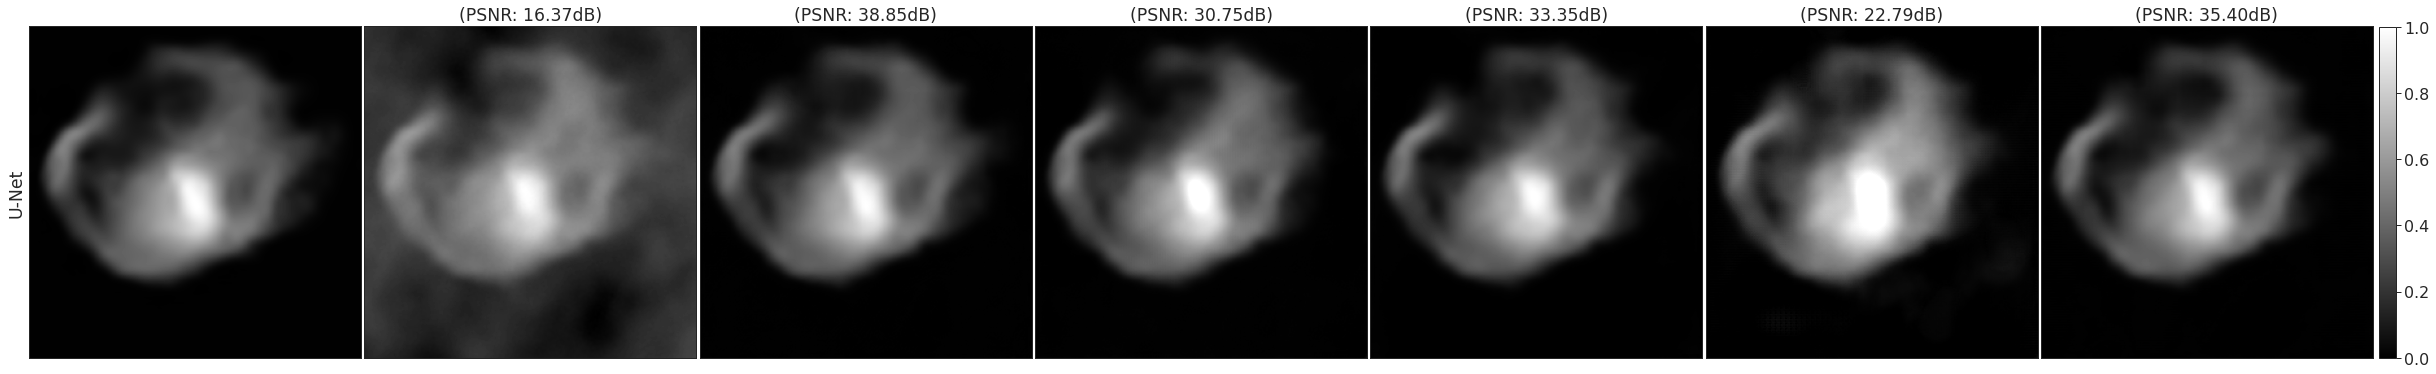

In [132]:

sns.set_context('paper', font_scale=1.8)
compare_multiple(np.array(res)[:,0], titles=titles, rot=2, nrows=1, ncols=4, colorbar=True, cbar_anchor=(1.25,.5), same_scale=True, vmin=0, vmax=1, cmap="viridis", ylabel="U-Net")
plt.savefig("./plots_ri/examples_TNG_UNet_0.pdf")

true = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

# # rotations = [0, 2, 0, 0]
for i in range(1,5):
    sns.set_context('paper', font_scale=1.8)
    compare_multiple(np.array(res)[:,i], nrows=1, ncols=len(titles), colorbar=True, cbar_anchor=(1.25,.5), same_scale=True, vmin=0, vmax=1, cmap="gray", ylabel="U-Net")
    plt.savefig(f"./plots_ri/examples_TNG_UNet_{i}.pdf")

In [53]:
tng_results = [
#     ("Dirty Image", "PseudoInverse", ""),
#     ("Primal-Dual", "PD", ""), 
#     ("Unet known", "UNet_var", "_known"),
#     ("Unet general", "UNet_var", "_general"),    
#     ("Unet general2known", "UNet_var", "_general_known"),
#     ("Unet specific2known", "UNet_var", "_specific_known"),
    
#     ("GUnet known", "GUNet_var", "_known"),
#     ("GUnet general", "GUNet_var", "_general"),
#     ("GUnet specific2known", "GUNet_var", "_specific_known"),
#     ("GUnet general2known", "GUNet_var", "_general_known"),
         
    ("True\ncoverage", "GUNet_var", "_known_new"), 
    ("Single\ncoverage", "GUNet_var", "_specific_new2"),
    ("Single\ncoverage\ntransfer", "GUNet_var", "_specific_known_new"),
    ("Distribution\nof coverages", "GUNet_var", "_general_new"),
    ("Distribution\nof coverages\ntransfer", "GUNet_var", "_general_known_new"), 
    
          
#     ("Full-knowledge", "GUNet_var", "_known_new"),
#     ("General model", "GUNet_var", "_general_new"),
#     ("Fine-tuned model", "GUNet_var", "_specific_known_new"),
    
#     ("GUnet general2known_new", "GUNet_var", "_general_known_new"),     
#     ("GUnet known weighted", "GUNet_var", "_known_weighted"),
#     ("GUnet general weighted", "GUNet_var", "_general_weighted"),
#     ("GUnet specific2known weighted", "GUNet_var", "_specific_known_weighted"),
#     ("GUnet general2known weighted", "GUNet_var", "_general_known_weighted"),
]

for operator in ["NUFFT_Random_var"]:
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "Method", "set"])

    for name, network, post in tng_results:
        try:
            df = pd.read_csv(f"./results/TNG/{operator}/statistics_{network}_{ISNR}dB{post}.csv")            
            df["name"] = name
            sel = abs(df["SSIM"] - np.median(df["SSIM"]))/np.median(df["SSIM"]) > 0.10 
            df = df[~sel]
            if statistics.empty:
                statistics = df
            else:
                statistics = statistics.append(df, ignore_index=False)
            print("loaded", network, post)
        except:
            pass
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True) 

loaded GUNet_var _known_new
loaded GUNet_var _specific_new2
loaded GUNet_var _specific_known_new
loaded GUNet_var _general_new
loaded GUNet_var _general_known_new


In [54]:
print_statistics(statistics, [(f"{j} NUFFT_Random_var {k[1:]}", "train", k) for i,j,k in tng_results], metrics)

Name                                                                       |PSNR                |SSIM                |MSE                 |
GUNet_var NUFFT_Random_var known_new_train                                 |  55.908 \pm   2.130|   0.999 \pm   0.001|   0.000 \pm   0.000|
GUNet_var NUFFT_Random_var specific_new2_train                             |  54.325 \pm   2.296|   0.999 \pm   0.001|   0.000 \pm   0.000|
GUNet_var NUFFT_Random_var specific_known_new_train                        |  55.011 \pm   1.688|   0.998 \pm   0.001|   0.000 \pm   0.000|
GUNet_var NUFFT_Random_var general_new_train                               |  51.664 \pm   1.758|   0.995 \pm   0.001|   0.000 \pm   0.000|
GUNet_var NUFFT_Random_var general_known_new_train                         |  54.644 \pm   2.072|   0.999 \pm   0.001|   0.000 \pm   0.000|


In [55]:
print_statistics(statistics, [(f"{j} NUFFT_Random_var {k[1:]}", "test", k) for i,j,k in tng_results], metrics)

Name                                                                       |PSNR                |SSIM                |MSE                 |
GUNet_var NUFFT_Random_var known_new_test                                  |  56.091 \pm   2.013|   0.999 \pm   0.001|   0.000 \pm   0.000|
GUNet_var NUFFT_Random_var specific_new2_test                              |  54.555 \pm   2.094|   0.999 \pm   0.001|   0.000 \pm   0.000|
GUNet_var NUFFT_Random_var specific_known_new_test                         |  55.125 \pm   1.486|   0.998 \pm   0.000|   0.000 \pm   0.000|
GUNet_var NUFFT_Random_var general_new_test                                |  51.799 \pm   1.551|   0.995 \pm   0.001|   0.000 \pm   0.000|
GUNet_var NUFFT_Random_var general_known_new_test                          |  54.755 \pm   1.870|   0.999 \pm   0.001|   0.000 \pm   0.000|


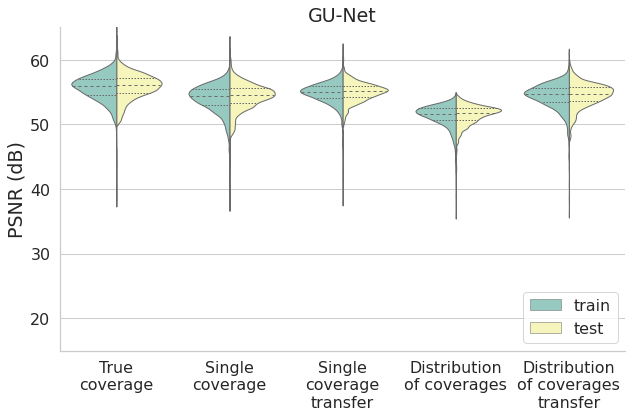

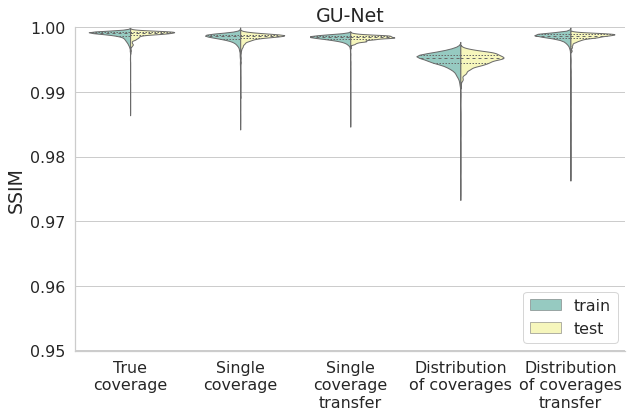

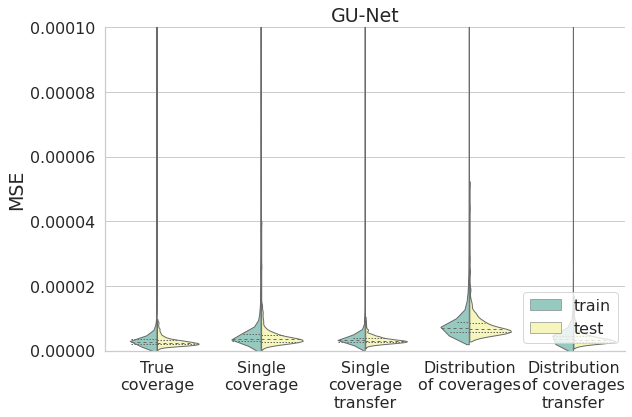

In [56]:
sns.set_context("notebook", font_scale=1.1)
plot_statistics(statistics, metrics, ylims=[[15,65], [0.95,1], [0, 0.0001]], save_base="./plots_ri/TNG_violin_GUNet_", rot=0, title="GU-Net")#, order=["PseudoInverse", "PD", "UNet", "GUnet"])

In [64]:
tng_results = [
    ("Dirty image", "PseudoInverse", ""),
    ("True coverage", "GUNet_var", "_known_new"),
    ("Single coverage", "GUNet_var", "_specific_new2"),
    ("Single coverage transfer", "GUNet_var", "_specific_known_new"),
    ("Distribution of coverages", "GUNet_var", "_general_new"),    
    ("Distribution of coverages transfer", "GUNet_var", "_general_known_new"),
]
         
data="TNG"
operator = "NUFFT_Random_var"

true = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")
sel = [2, 6, 8, 11,  21]
res = [[true[i] for i  in sel]]
titles = ["Reference"]

for name, network, post in tng_results:
    try:
#         print(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res.append([ims[i] for i  in sel])
        titles.append(name)
    except:
        pass

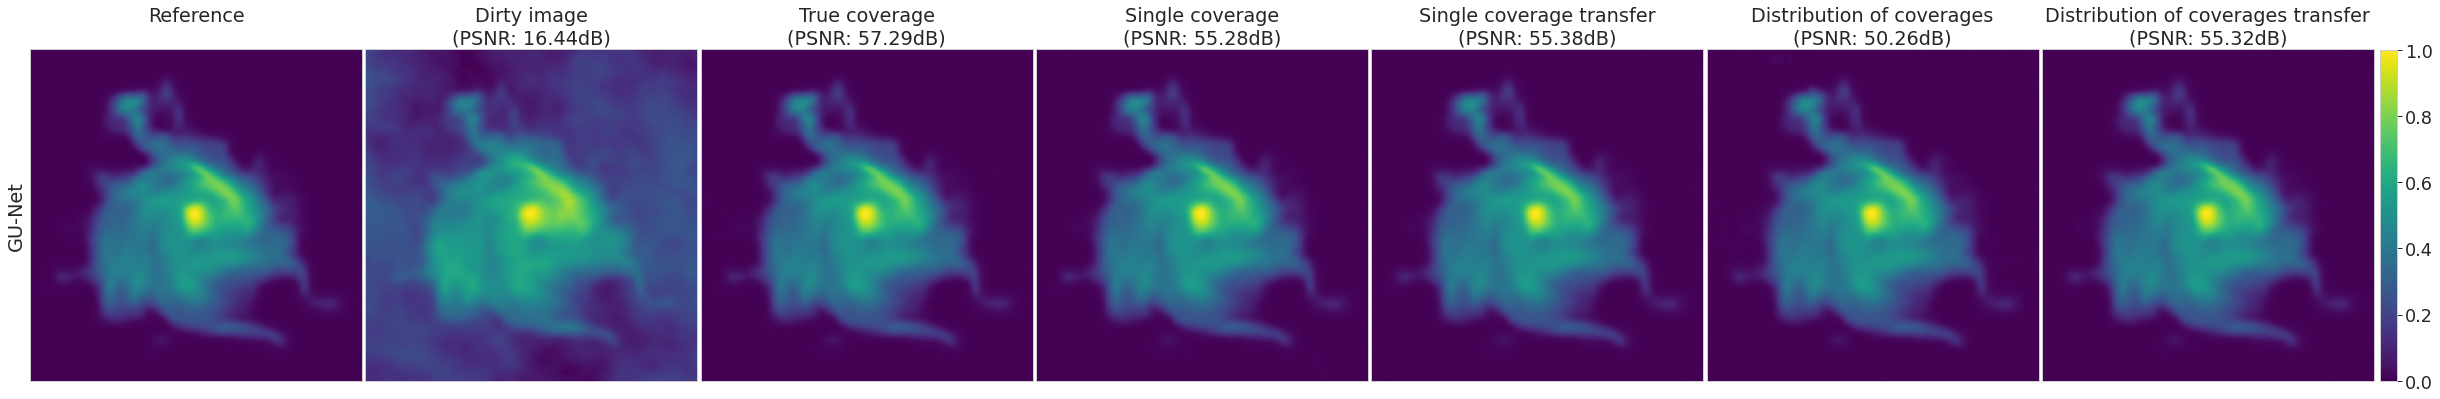

In [65]:
# for poster: 
# sns.set_context('paper', font_scale=1.8)
sns.set_context('paper', font_scale=2.0)
compare_multiple(np.array(res)[:,0], titles=titles, rot=2, nrows=1, ncols=4, colorbar=True, cbar_anchor=(1.25,.5), same_scale=True, vmin=0, vmax=1, cmap="viridis", ylabel="GU-Net")
plt.savefig("./plots_ri/examples_TNG_GUNet_0_poster.pdf")

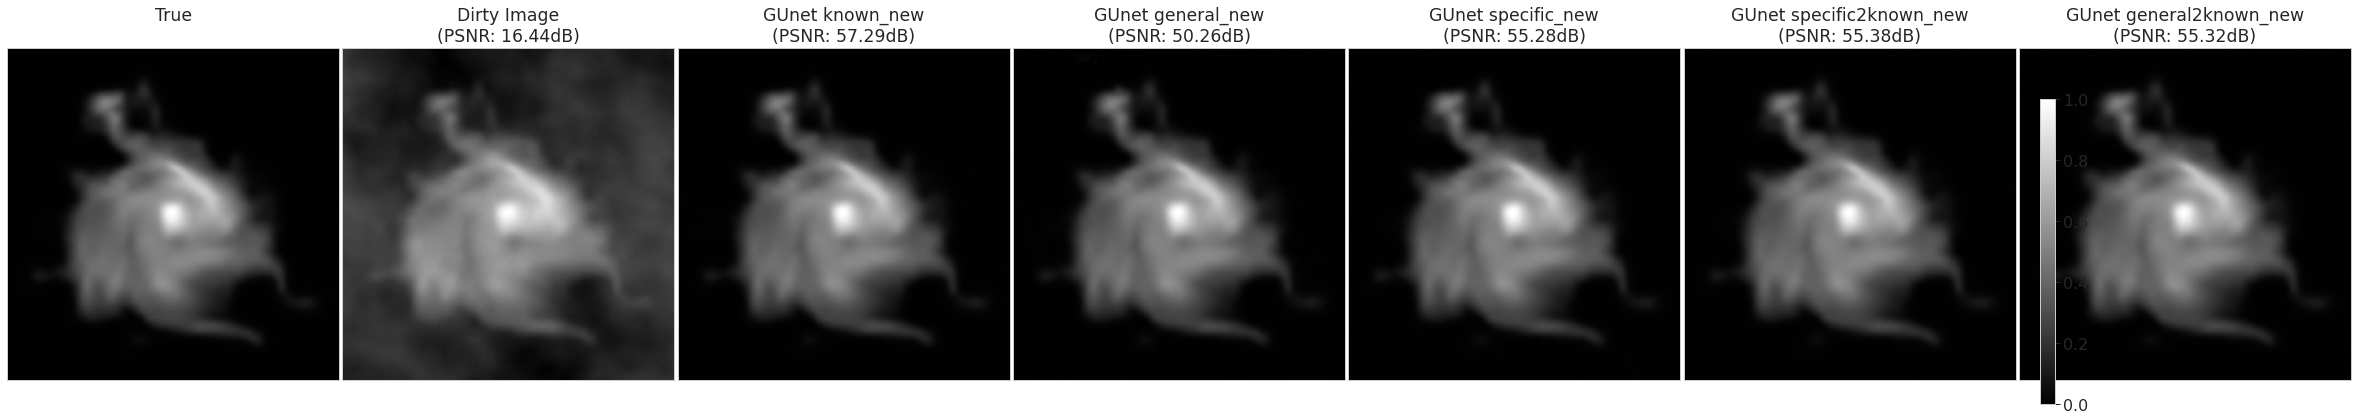

In [82]:
sns.set_context('paper', font_scale=1.8)
compare_multiple(np.array(res)[:,0], titles=titles, rot=2, nrows=1, ncols=4, colorbar=True, cbar_anchor=1 + .2/5*3, same_scale=True, vmin=0, vmax=1, cmap="gray")
plt.savefig("./plots/examples_TNG_GUNet_0.pdf")

# # rotations = [0, 2, 0, 0]
# for i in range(1,5):
#     sns.set_context('paper', font_scale=1.8)
#     compare_multiple(np.array(res)[:,i], nrows=1, ncols=3, colorbar=True, cbar_anchor=1 + .2/5*3, same_scale=True, vmin=0, vmax=1, cmap="gray")
#     plt.savefig(f"./plots_ri/examples_TNG_GUNet_{i}.pdf")

In [26]:
tng_results

[('GUnet known_new', 'GUNet_var', '_known_new'),
 ('GUnet general_new', 'GUNet_var', '_general_new'),
 ('GUnet specific2known_new', 'GUNet_var', '_specific_known_new'),
 ('GUnet general2known_new', 'GUNet_var', '_general_known_new')]


_known
_general
_general_known
_specific_known


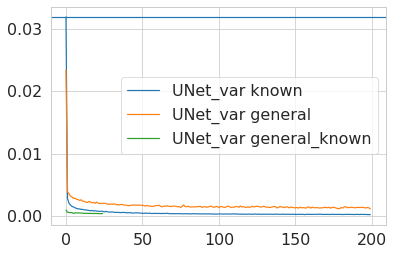

In [92]:
operator = "NUFFT_Random_var"

for name, network, post in tng_results:
    print(post)
    try:
        l = np.loadtxt(f"./logs/TNG/{operator}/log_{network}_{ISNR}dB{post}", delimiter=",", skiprows=1)
        plt.plot(l[:,1], label = network + " " + post[1:])
        if post.startswith("_known"):
            plt.axhline(l[:,1].max())
    except:
        pass
plt.legend()
# plt.yscale('log')

plt.show()

In [70]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


In [90]:
tng_results = [
    ("True coverage", "UNet_var", "_known_new2"),
    ("Single coverage", "UNet_var", "_specific_new2"),
    ("Single coverage\ntransfer", "UNet_var", "_specific_known_new2"),
    ("Distribution\nof coverages", "UNet_var", "_general_new2"),    
    ("Distribution\nof coverages\ntransfer", "UNet_var", "_general_known_new2"),
    ("True coverage", "GUNet_var", "_known_new"),  
    ("Single coverage", "GUNet_var", "_specific_new2"),
    ("Single coverage\ntransfer", "GUNet_var", "_specific_known_new"),
     ("Distribution\nof coverages", "GUNet_var", "_general_new"),
    ("Distribution\nof coverages\ntransfer", "GUNet_var", "_general_known_new"),
]

_known_new2
4.8015621980031336
_specific_new2
4.669910117917591
_specific_known_new2
0.3198789995246463
_general_new2
5.01496512485875
_general_known_new2
0.36092285911242167
_known_new
27.135690116286277
_specific_new2
26.37924231323931
_specific_known_new
2.6539151430130006
_general_new
26.61231476638052
_general_known_new
2.656021649506357


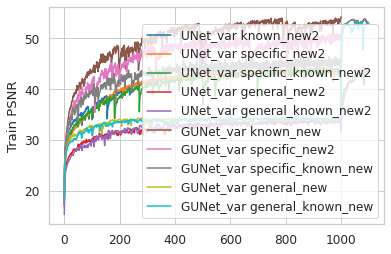

In [91]:
operator = "NUFFT_Random_var"


names, times = [], []
hue = []

for name, network, post in tng_results:
    print(post)
    l = np.loadtxt(f"./logs/TNG/{operator}/log_{network}_{ISNR}dB{post}", delimiter=",", skiprows=1)
    plt.plot(running_mean(l[:,1],1), label = network + " " + post[1:])
    print(l[-1,-3]/3600)
    names.append(name)
    net = network.split("_")[0]
    hue.append(net[:-3] + "-" + net[-3:])
    if not name.endswith("ransfer") and not name.startswith("True"):
        times.append(0)
    elif name.startswith("True"):
        times.append(l[-1,-3]/3600 + 23.333)
    else:
        times.append(l[-1,-3]/3600)
plt.legend()
# plt.yscale('log')
# plt.axis(xmin=1000)
plt.ylabel("Train PSNR")
plt.show()

In [92]:
df = pd.DataFrame()

In [93]:
df['times'] = times
df['name'] = names
df['Network'] = hue

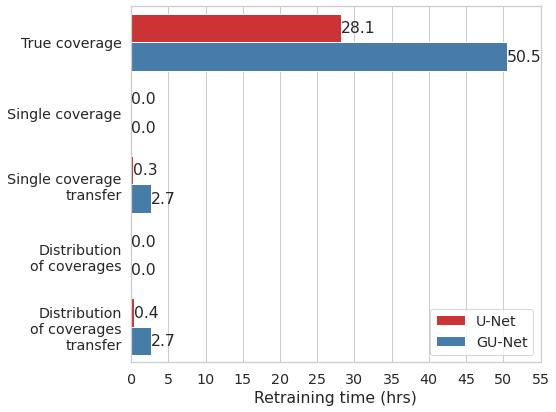

In [103]:
sns.set_style("whitegrid")
sns.set_context('notebook', font_scale=1.3)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=df, x='times', y='name', hue='Network', orient='h', palette="Set1", )
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')

plt.axis(xmax=55)
plt.xticks(np.arange(0,56, 5))
plt.xlabel("Retraining time (hrs)")
plt.ylabel("")
plt.legend(loc=4)
plt.tight_layout()
plt.savefig("./plots_ri/train_times.pdf")

In [46]:
pip install matplotlib==3.4

     |████████████████████████████████| 10.3 MB 34.6 MB/s eta 0:00:01    |██████████████▊                 | 4.7 MB 34.6 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.0
    Uninstalling matplotlib-3.3.0:
      Successfully uninstalled matplotlib-3.3.0
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs000000029dca65710000005e'

Note: you may need to restart the kernel to use updated packages.


In [37]:
for j in i:
    print()

Rectangle(xy=(0, -0.4), width=24.8016, height=0.4, angle=0)
Rectangle(xy=(0, 0.6), width=0, height=0.4, angle=0)
Rectangle(xy=(0, 1.6), width=0.360923, height=0.4, angle=0)
Rectangle(xy=(0, 2.6), width=0, height=0.4, angle=0)
Rectangle(xy=(0, 3.6), width=0.319879, height=0.4, angle=0)


_known_new


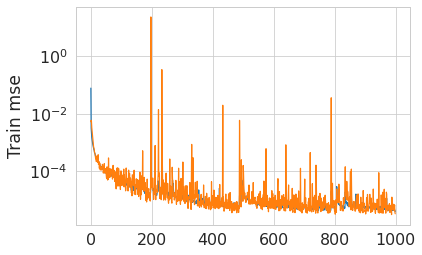

In [78]:
operator = "NUFFT_Random_var"

for name, network, post in tng_results:
    print(post)
    try:
        l = np.loadtxt(f"./logs/TNG/{operator}/log_{network}_{ISNR}dB{post}", delimiter=",", skiprows=1)
        plt.plot(running_mean(l[:,2],1), label = network + " " + post[1:])
        plt.plot(running_mean(l[:,-1],1), label = network + " " + post[1:])
        
#         if post.startswith("_known"):
#             plt.axhline(l[:,1].max())

        break
    except:
        pass
# plt.legend()
plt.yscale('log')
plt.ylabel("Train mse")
plt.show()


_known_new
_general_new
_specific_new2


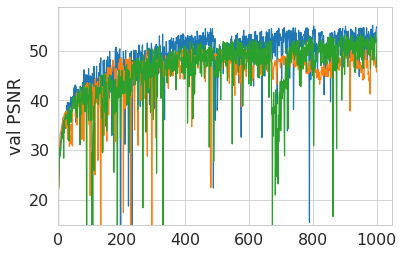

In [160]:
operator = "NUFFT_Random_var"

for name, network, post in tng_results[:4]:
    print(post)
    try:
        l = np.loadtxt(f"./logs/TNG/{operator}/log_{network}_{ISNR}dB{post}", delimiter=",", skiprows=1)
        plt.plot(running_mean(l[:,4],1), label = network + " " + post[1:])
#         plt.plot(running_mean(l[:,-2],1), label = network + " " + post[1:])
#         if post.startswith("_known"):
#             plt.axhline(l[:,4].max())
#         elif post.endswith("specific_known_new"):
#             print(np.argmax(l[:,4]))
#             plt.axvline(np.argmax(l[:,4]), ls='--')
#         elif post.endswith("general_known_new"):
#             print(np.argmax(l[:,4]))
#             plt.axvline(np.argmax(l[:,4]), ls='-.')
#         break
    except:
        pass
# plt.legend()
# plt.yscale('log')
plt.axvline()
plt.ylabel("val PSNR")
plt.axis(xmin=0, ymin=15)
# plt.axis(xmin=1000, ymin=15)
plt.show()

In [36]:
l = np.loadtxt(f"./logs/TNG/{operator}/log_{network}_{ISNR}dB_known_new", delimiter=",", skiprows=1)

In [37]:
l[0]

array([0.00000000e+00, 1.74824848e+01, 8.47481862e-02, 1.12640478e+02,
       1.86942158e+01, 1.35233002e-02])

In [54]:
import glob

In [55]:
files = glob.glob("/home/mars/git/IllustrisTNG/data/processed_256/TNG*.npy")



In [60]:
random_files = np.random.permutation(files)

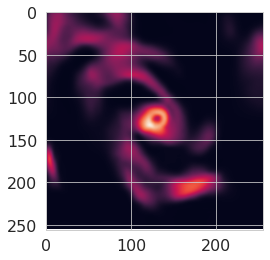

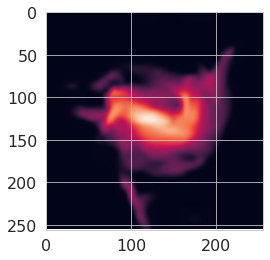

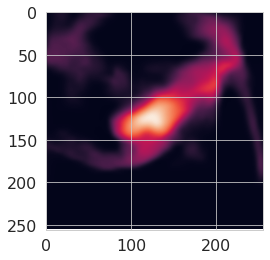

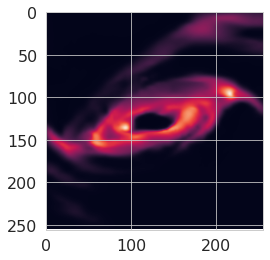

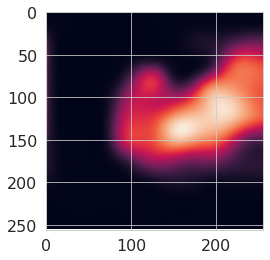

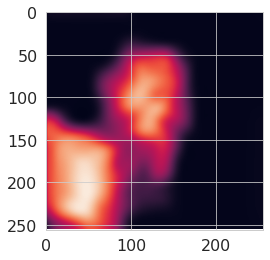

In [61]:
for i in [0, 1, 2, -1, -2, -3]:
    im = np.load(random_files[i])
    plt.imshow(im)
    plt.show()

_known_new
_general_new
_specific_known_new
_general_known_new


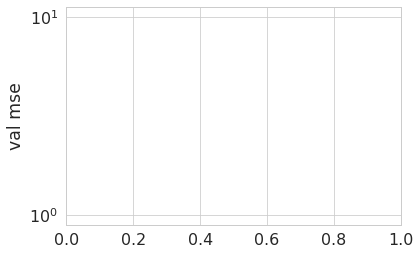

In [74]:
operator = "NUFFT_Random_var"

for name, network, post in tng_results:
    print(post)
    try:
        l = np.loadtxt(f"./logs/TNG/{operator}/log_{network}_{ISNR}dB{post}", delimiter=",", skiprows=1)
        plt.plot(running_mean(l[:,-1], 30), label = network + " " + post[1:])
#         if post.startswith("_known"):
#             plt.axhline(l[:,1].max())
        print(f"PSNR train {np.max(l[:,1]):.3f}")
        print(f"PSNR val {np.max(l[:,4]):.3f}")
        print(f"MSE train {np.min(l[:,2]):.3e}")
        print(f"MSE Val {np.min(l[:,5]):.3e}")
    
    except:
        pass
# plt.legend()
plt.yscale('log')
plt.ylabel("val mse")
# plt.axis(ymax=1e-1)
plt.show()

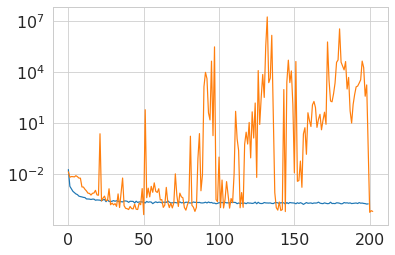

In [39]:
plt.plot(pd.read_csv(f"./logs/TNG/{operator}/log_{network}_{ISNR}dB_known").loss)
plt.plot(pd.read_csv(f"./logs/TNG/{operator}/log_{network}_{ISNR}dB_specific_known").val_loss)
plt.yscale('log')

In [42]:
ame, network, postfix = ("GUnet", "GUNet_var", "_general")
data = "TNG"

test = np.load(f"data/intermediate/{data}/{operator}/x_true_train_{ISNR}dB.npy")

train_predict = np.load(f"data/processed/{data}/{operator}/train_predict_{network}_{ISNR}dB" + postfix + ".npy")
test_predict = np.load(f"data/processed/{data}/{operator}/test_predict_{network}_{ISNR}dB" + postfix + ".npy")

name, network, postfix = ("GUnet", "GUNet_var", "_specific_general")
train_predict2 = np.load(f"data/processed/{data}/{operator}/train_predict_{network}_{ISNR}dB" + postfix + ".npy")
# train_predict2 = np.ones_like(train_predict)

name, network, postfix = ("GUnet", "GUNet_var", "_known")
train_predict3 = np.load(f"data/processed/{data}/{operator}/train_predict_{network}_{ISNR}dB" + postfix + ".npy")

name, network, postfix = ("GUnet", "GUNet_var", "_specific_known")
train_predict4 = np.load(f"data/processed/{data}/{operator}/train_predict_{network}_{ISNR}dB" + postfix + ".npy")
# train_predict4 = np.ones_like(train_predict)


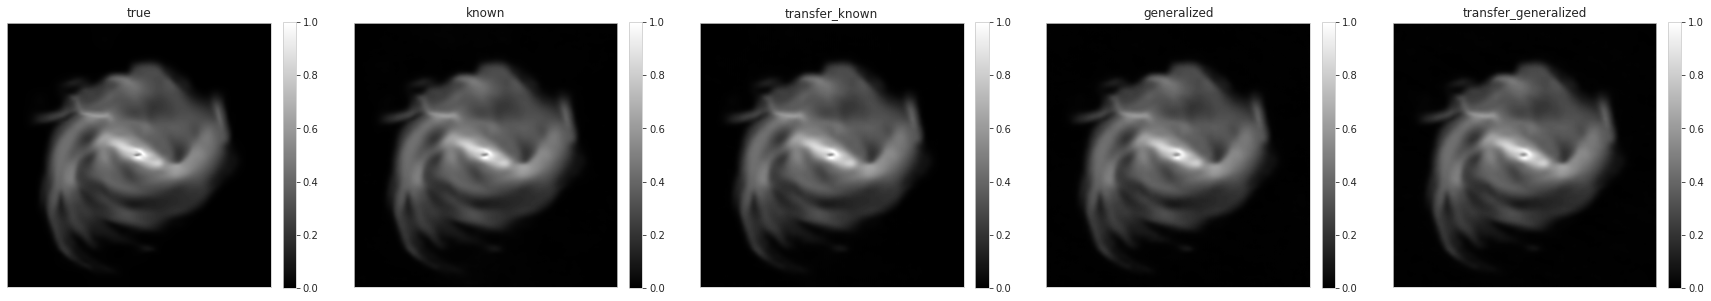

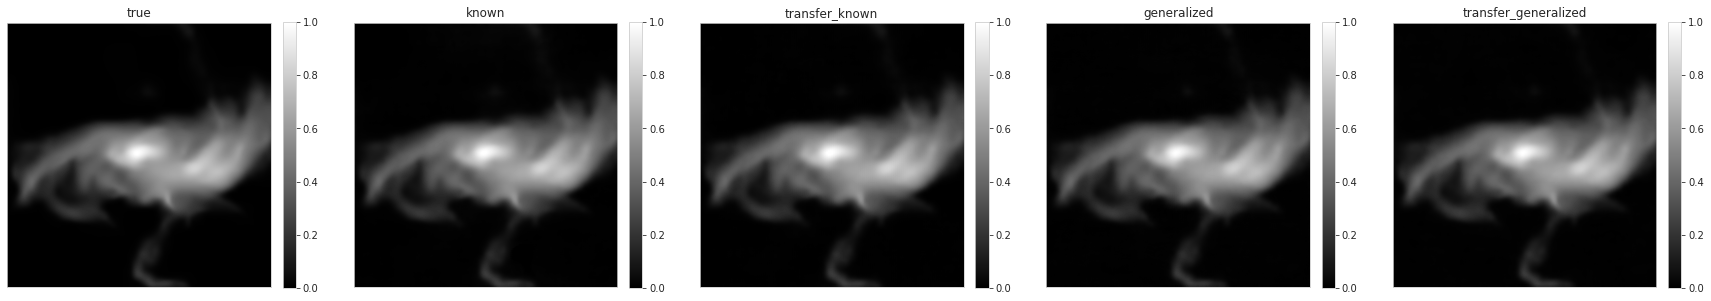

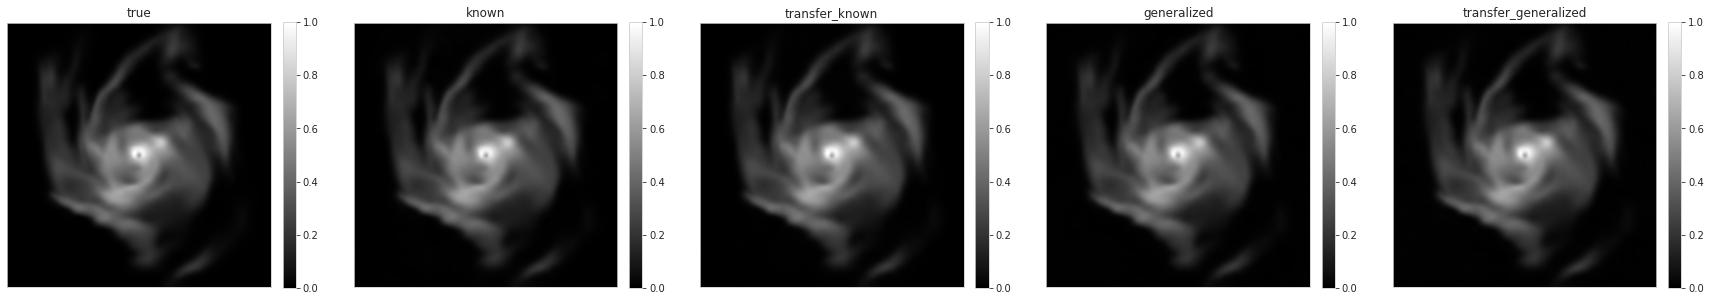

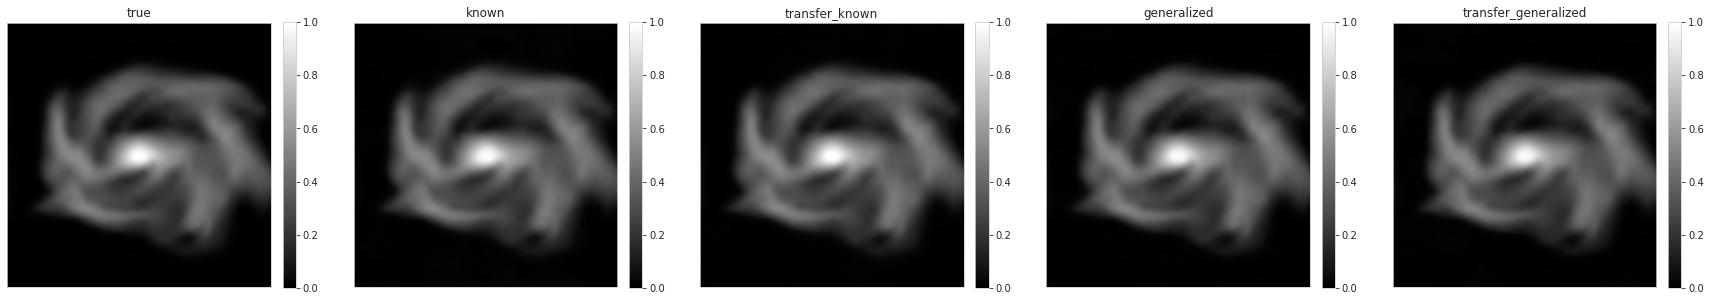

In [28]:
i = 266
compare([test[i], train_predict3[i], train_predict4[i], train_predict[i], train_predict2[i]], titles=["true", "known", "transfer_known", "generalized", "transfer_generalized"], cmap='gray', same_scale=True, colorbar=True)
plt.show()
i = 478
compare([test[i], train_predict3[i], train_predict4[i], train_predict[i], train_predict2[i]], titles=["true", "known", "transfer_known", "generalized", "transfer_generalized"], cmap='gray', same_scale=True, colorbar=True)
plt.show()
i = 360
compare([test[i], train_predict3[i], train_predict4[i], train_predict[i], train_predict2[i]], titles=["true", "known", "transfer_known", "generalized", "transfer_generalized"], cmap='gray', same_scale=True, colorbar=True)
plt.show()
i = 1728
compare([test[i], train_predict3[i], train_predict4[i], train_predict[i], train_predict2[i]], titles=["true", "known", "transfer_known", "generalized", "transfer_generalized"], cmap='gray', same_scale=True, colorbar=True)
plt.show()

In [50]:
a = pd.read_csv("./results/TNG/NUFFT_Random_var/statistics_GUNet_var_30dB_generalized.csv")

In [51]:
np.where(a['MSE'] >0.001)

(array([], dtype=int64),)

In [52]:
i = 2004
compare([test[i], train_predict3[i], train_predict4[i], train_predict[i], train_predict2[i]], titles=["true", "known", "transfer_known", "generalized", "transfer_generalized"], cmap='gray', same_scale=True, colorbar=True)
plt.show()

IndexError: index 2004 is out of bounds for axis 0 with size 2000

In [ ]:
plt.imshow(test_predict[4])

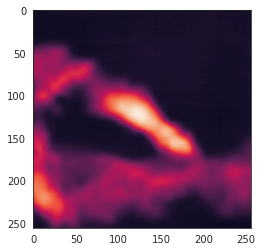

In [53]:
plt.imshow(test_predict[969])

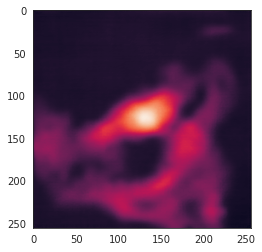

In [54]:
plt.imshow(test_predict[984])